In [1]:
# importing the required packages
using JetReconstruction
using LorentzVectorHEP
import LorentzVectorHEP.eta
# include("JetReconstruction.jl-main/src/ClusterSequence.jl")

using Plots
using StatsBase 



### Implementing functions to load data from a file

In [2]:
# function to read the full data file 
function readFile(file::Int64)
    datafile = open("./total/$(file).txt","r")
    lines = readlines(datafile)
    close(datafile)

    lines
end;

# function to create PseudoJets from a set of data
# taking in px, py, pz, E of the particle
function loadParticles(lines::Array{String})
    jetData = Vector{PseudoJet}(undef, length(lines))

    i = 1
    for line in lines
        
        arr = split(line, "\t")           
        px = parse(Float64, arr[1])
        py = parse(Float64, arr[2])
        pz = parse(Float64, arr[3])
        E = parse(Float64, arr[4])
        
        jetData[i] = PseudoJet(px, py, pz, E)
        i += 1
    end

    jetData
end;

# function for jet reconstruction
# uses Cambridge-Aachen algorithm with jet radius 1.0
function makeJets(data::Vector{PseudoJet})
    finaljets = plain_jet_reconstruct(data; p = 0, R = 1.2)
    finaljets
end;

function get_inclusive_jets(clusterseq::ClusterSequence, ptmin = 0.0)
    jets = Vector{PseudoJet}(undef, 0)
    dcut = ptmin * ptmin

    for elt in clusterseq.history
        elt.parent2 == BeamJet || continue;
        iparent_jet = clusterseq.history[elt.parent1].jetp_index;
        jet = clusterseq.jets[iparent_jet];
    
        if (pt2(jet) >= dcut)
            push!(jets, jet);
        end;
    
    end;

    jets
end;


### Implementing histogram plotting function


In [3]:
function plotHIST(jets::Vector{PseudoJet}, choice::Int)
    NUM = length(jets)
    values = []
    
    if (choice === 1)
        for j in 1:NUM
            pt = pt2(jets[j]) ^ 0.5
            push!(values, pt)
        end

    elseif(choice === 2)
        for j in 1:NUM
            pseuRap = eta(jets[j])
            # push!(values, pseuRap)
            -100 < pseuRap < 100 ? push!(values, pseuRap) : continue
        end
        
    elseif(choice === 3)
        for j in 1:NUM
            PHI = phi(jets[j])
            push!(values, PHI)
        end

    else
        println("Enter a valid choice.")
        return
    end


    MIN = minimum(values)
    MAX = maximum(values)

    x = LinRange(MIN, MAX+1, 51)

    println("Mean = $(mean(values))")
    println("Standard deviation = $(std(values))")
    display(histogram(values, bins=x))#, yaxis=(:log10)))
    # savefig(histogram(pt, bins=x, yaxis=(:log10)), "pt-julia.png")
    # sleep(10)
end;

### Implementing the Mass Drop Tagger

In [4]:
m2(p) = JetReconstruction.m2(p);
pt2(p) = JetReconstruction.pt2(p);
eta(p) = JetReconstruction.eta(p);
phi(p) = JetReconstruction.phi(p);
NonexistentParent = JetReconstruction.NonexistentParent;
BeamJet = JetReconstruction.BeamJet;

struct MassDropTagger
    mu::Float64
    y::Float64
end;

function has_parents(jet, history)
    N = jet._cluster_hist_index
    history[N].parent1 === history[N].parent2 === NonexistentParent ? result = false : result = true
    result, history[N].parent1, history[N].parent2
end;

# Function to calculate ΔR
function delta_R(eta1, phi1, eta2, phi2)
    d_eta = eta1 - eta2
    d_phi = phi1 - phi2
    d_phi = abs(d_phi) > π ? 2π - abs(d_phi) : d_phi
    return sqrt(d_eta^2 + d_phi^2)
end;

# Function to calculate kt distance between two pseudojets
function kt_distance(jet1::PseudoJet, jet2::PseudoJet, R = 1)
    pt1 = sqrt(jet1._pt2)
    pt2 = sqrt(jet2._pt2)
    eta1, phi1 = jet1._rap, jet1._phi
    eta2, phi2 = jet2._rap, jet2._phi
    d_R = delta_R(eta1, phi1, eta2, phi2)
    return min(pt1^2, pt2^2) * (d_R^2 / R^2)
end;

function apply_massdrop(jet::PseudoJet, clusterseq::ClusterSequence, tag::MassDropTagger)
    allJets = clusterseq.jets
    hist = clusterseq.history

    while(true)
        had_parents, p1, p2 = has_parents(jet, hist)

        if (had_parents)
            parent1 = allJets[hist[p1].jetp_index]
            parent2 = allJets[hist[p2].jetp_index]

            if (m2(parent1) < m2(parent2))
                p1, p2 = p2, p1
                parent1, parent2 = parent2, parent1
            end

            if ((m2(parent1) < m2(jet)*tag.mu^2) && (kt_distance(parent1, parent2) > tag.y*m2(jet)))
                return jet
            else
                jet = parent1
            end
    
        else 
            return PseudoJet(0.0, 0.0, 0.0, 0.0)
        end

    end

end;


In [22]:
fullData = readFile(0)
particles = loadParticles(fullData)

# particles = [
#     PseudoJet(1.0, 0.0, 0.0, 1.0),
#     PseudoJet(0.0, 1.0, 0.0, 1.0),
#     PseudoJet(0.0, 0.0, 1.0, 1.0),
#     PseudoJet(1.0, 1.0, 0.0, 1.414),
#     ]
    
data = makeJets(particles)
actual = inclusive_jets(data)
hist = data.history
# jet = data.jets

mdt = MassDropTagger(0.67, 0.09)
N = length(actual)
count = 1

println(N)

ptmin = 0.0

allJets = get_inclusive_jets(data, ptmin)
taggedJets = Vector{PseudoJet}(undef, 0)


for jet in allJets
    global count
    trial = apply_massdrop(jet, data, mdt)
    push!(taggedJets, trial)
    println(count, "\tOriginal jet: pt = $(pt2(jet) ^ 0.5), eta = $(eta(jet)), phi = $(phi(jet)), E = $(jet.E)")
    println(count, "\tTagged jet: pt = $(pt2(trial) ^ 0.5), eta = $(eta(trial)), phi = $(phi(trial)), E = $(trial.E)")
    println()
    count += 1
end


31
1	Original jet: pt = 27.44875472378298, eta = 3.5109515360570223, phi = 2.6636891667464155, E = 460.05374615989024
1	Tagged jet: pt = 0.0, eta = 0.0, phi = 0.0, E = 0.0

2	Original jet: pt = 0.5417155462293578, eta = 3.4562040581448845, phi = 1.19537932811121, E = 8.610573497301736
2	Tagged jet: pt = 0.0, eta = 0.0, phi = 0.0, E = 0.0

3	Original jet: pt = 1.394890447346123, eta = -4.581698759446607, phi = 5.11347031038029, E = 68.14141271205467
3	Tagged jet: pt = 1.394890447346123, eta = -4.581698759446607, phi = 5.11347031038029, E = 68.14141271205467

4	Original jet: pt = 0.45533141847322944, eta = 4.857244884104191, phi = 5.214215616790871, E = 29.295757484079278
4	Tagged jet: pt = 0.45533141847322944, eta = 4.857244884104191, phi = 5.214215616790871, E = 29.295757484079278

5	Original jet: pt = 0.12065527404665245, eta = -4.458322120482335, phi = 2.103846214342461, E = 5.209730188433046
5	Tagged jet: pt = 0.12065527404665245, eta = -4.458322120482335, phi = 2.103846214342461, E

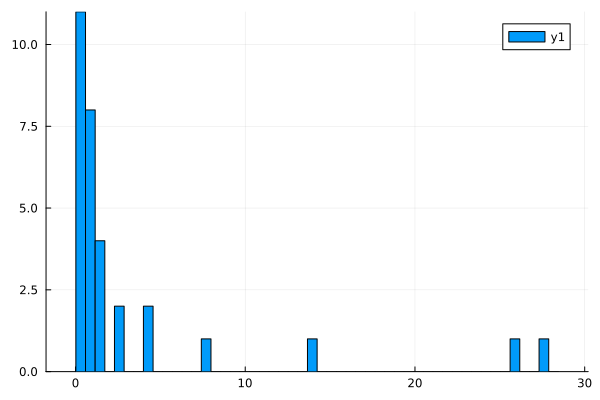

Mean = 3.3559207232763457
Standard deviation = 6.7774747244964075


In [24]:
plotHIST(allJets, 1)

### Implementing Jet Filtering

In [7]:
struct Filter
    filterRadius::Float64 
    numHardestJets::Int
end;

function jet_constituents(jet::PseudoJet, clusterseq::ClusterSequence)
    constituents = Vector{PseudoJet}(undef, 0)
    
    hist = clusterseq.history
    allJets = clusterseq.jets

    had_parents, p1, p2 = has_parents(jet, hist)

    if (had_parents)
        parent1 = allJets[hist[p1].jetp_index]
        parent2 = allJets[hist[p2].jetp_index]

        append!(constituents,jet_constituents(parent1, clusterseq))
        append!(constituents,jet_constituents(parent2, clusterseq))
    else 
        push!(constituents, jet)
        return constituents
    end 

end;

function sort_jets!(event_jet_array)
    jet_pt(jet) = pt2(jet)
    sort!(event_jet_array, by = jet_pt, rev = true)
end;

function join(jets::Vector{PseudoJet})
    px = py = pz = E = 0.0

    for jet in jets
        px += jet.px
        py += jet.py
        pz += jet.pz
        E += jet.E
    end

    combinedJet = PseudoJet(px, py, pz, E)
    combinedJet
end;

function apply_filter(jet::PseudoJet, clusterseq::ClusterSequence, filter::Filter)
    constituents = jet_constituents(jet, clusterseq);
    rad = filter.filterRadius;
    
    reclustered = get_inclusive_jets(plain_jet_reconstruct(constituents; p = 0, R = rad));
    sort_jets!(reclustered);
    
    n = length(reclustered) <= filter.numHardestJets ? length(reclustered) : filter.numHardestJets 
    hard = reclustered[1:n]
    filtered = join(hard)
    
    filtered    
end;


### Using the Filter

In [8]:
F = Filter(0.3, 3);

for jet in allJets
    final = apply_filter(jet, data, F);
    println(pt2(final)^0.5);
end

# sort_jets!(allJets)
# xyz = Vector{PseudoJet}(undef, 2)
# xyz[1] = allJets[2]
# xyz[2] = allJets[3]

# println(xyz)

# jet = join(xyz)
# final = apply_filter(jet, data, F)
# println(final)


25.758793750661315
19.38426838643532
11.967935746488816
4.694510243121279


### Implementing Jet Trimming

In [11]:
struct Trim
    trimRadius::Float64
    trimFraction::Float64
    reclusterMethod::Int
end;

function apply_trim(jet::PseudoJet, clusterseq::ClusterSequence, trim::Trim)
    constituents = jet_constituents(jet, clusterseq);
    rad = trim.trimRadius;
    mtd = trim.reclusterMethod
    frac2 = trim.trimFraction ^ 2

    reclustered = get_inclusive_jets(plain_jet_reconstruct(constituents; p = mtd, R = rad));
    sort_jets!(reclustered);
    
    hard = Vector{PseudoJet}(undef, 0)
    for item in reclustered
        if pt2(item) >= frac2 * pt2(jet)
            push!(hard, item)
        end
    end
    trimmed = join(hard)
    
    trimmed    
end;

In [18]:
T = Trim(0.3, 0.3, 0);

for jet in allJets
    final = apply_trim(jet, data, T);
    println(pt2(final)^0.5);
end

24.0024657948891
11.39058332934317
8.958194272123187
0.0
